# Predicting Mercury’s elemental composition from Albedo with MESSENGER Data

Data source  - https://github.com/ML4SCI/ML4SCI_GSoC/tree/main/Messenger/Mercury

**Note - For final results jump to last section of this notebook**

### Importing important python libraries for plotting and data preprocessing

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
import warnings
warnings.filterwarnings('ignore')
from matplotlib.pyplot import figure
mpl.style.use('classic')
# %matplotlib inline

# from sklearn import metrics
sns.set()



# Part 1-  Data Preprocessing and Exploratory Data Analysis

 The data is stored in a CSV files with 360 rows and 720 columns. 
 
 The goal of data preprocessing is to convert the data in a format suitable for training and testing .
 

#### Step 1 - > Converting all the data frames into Numpy Matrix 

In [2]:
# 720*1440
Mercury_top = pd.read_csv("mercury-albedo-top-half.png.csv",header=None);
Mercury_bottom = pd.read_csv("mercury-albedo-resized-bottom-half.png.csv",header=None);

Al =  pd.read_csv("alsimap_smooth_032015.png.csv",header=None);
Mg =  pd.read_csv("mgsimap_smooth_032015.png.csv",header=None);
Ca  =  pd.read_csv("casimap_smooth_032015.png.csv",header=None);
S =  pd.read_csv("ssimap_smooth_032015.png.csv",header=None);
Fe =  pd.read_csv("fesimap_smooth_032015.png.csv",header=None);



mercury_top = Mercury_top.to_numpy()
mercury_bottom = Mercury_bottom.to_numpy()

al = Al.to_numpy() 
fe = Fe.to_numpy()
mg = Mg.to_numpy()
s = S.to_numpy()
ca = Ca.to_numpy()




flat_fe = fe.flatten()
flat_al = al.flatten()
flat_mg = mg.flatten()
flat_s = s.flatten()
flat_ca = ca.flatten()

flat_albedo = mercury_top.flatten()
data_train = {
      
        'Albedo':flat_albedo,'Fe':flat_fe,
        'Al':flat_al,'Mg':flat_mg,'S':flat_s,'Ca':flat_ca
} 



Plotting to the original to check if the above conversion of successful

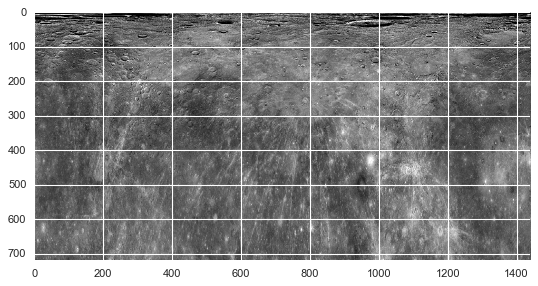

In [110]:
plt.imshow(mercury_top, cmap="gray") 
plt.show() 

In [4]:
train =  pd.DataFrame(data= data_train)

#### Step 3-> Lets do some EDA 

In [5]:
train.head()

,Albedo,Fe,Al,Mg,S,Ca
0,0.486275,0.0,0.0,0.0,0.0,0.0
1,0.498039,0.0,0.0,0.0,0.0,0.0
2,0.521569,0.0,0.0,0.0,0.0,0.0
3,0.529412,0.0,0.0,0.0,0.0,0.0
4,0.541176,0.0,0.0,0.0,0.0,0.0


**Lets get some insights about the data using info() and describe() methods.**

In [9]:
train.describe()

,Albedo,Fe,Al,Mg,S,Ca
count,1.036800e+06,1.036800e+06,1.036800e+06,1.036800e+06,1.036800e+06,1.036800e+06
mean,4.144590e-01,3.138895e-01,7.510351e-01,5.303197e-01,3.859588e-01,4.086300e-01
std,1.165033e-01,2.891811e-01,1.989632e-01,1.432387e-01,2.304556e-01,2.254984e-01
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.372549e-01,0.000000e+00,7.137255e-01,4.980392e-01,3.529412e-01,4.274510e-01
50%,4.039216e-01,4.549020e-01,8.039216e-01,5.411765e-01,4.509804e-01,4.941176e-01
75%,4.862745e-01,5.607843e-01,8.745098e-01,5.803922e-01,5.098040e-01,5.333334e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00


In [10]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036800 entries, 0 to 1036799
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Albedo  1036800 non-null  float64
 1   Fe      1036800 non-null  float64
 2   Al      1036800 non-null  float64
 3   Mg      1036800 non-null  float64
 4   S       1036800 non-null  float64
 5   Ca      1036800 non-null  float64
dtypes: float64(6)
memory usage: 47.5 MB


**Let's visualize the chemical compositions and Albedo data**

<AxesSubplot:xlabel='Albedo', ylabel='Density'>

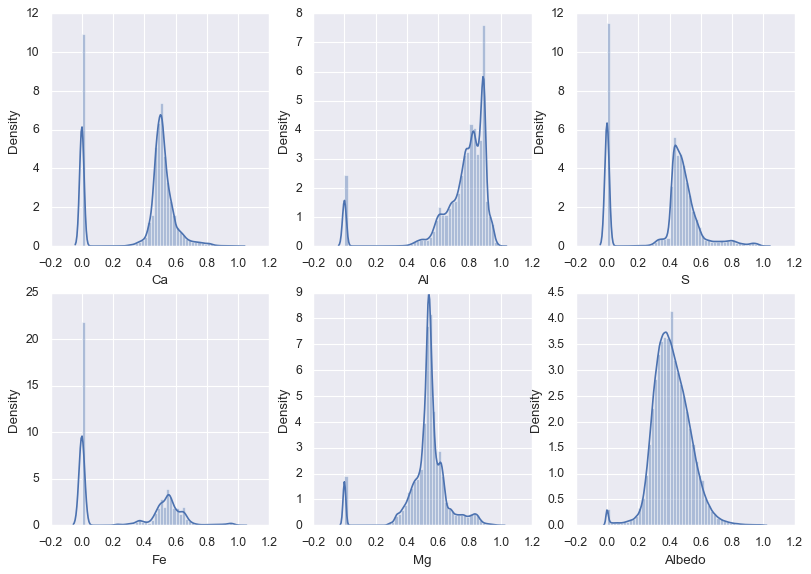

In [11]:
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2, 3, 1)
sns.distplot(train['Ca'])

plt.subplot(2, 3, 2)
sns.distplot(train['Al'])

plt.subplot(2, 3, 3)
sns.distplot(train['S'])

plt.subplot(2, 3, 4)
sns.distplot(train['Fe'])

plt.subplot(2, 3, 5)
sns.distplot(train['Mg'])

plt.subplot(2, 3, 6)
sns.distplot(train['Albedo'])


## Ingsights from the plots above

- Almost all of the element variables have high no. of zeros indicating missing data. Lets print out the zeros in the chemicals



In [13]:
print("No. of zeros in Al -> ",np.count_nonzero(flat_al==0))
print("No. of zeros in Mg -> ",np.count_nonzero(flat_mg==0))
print("No. of zeros in Fe -> ",np.count_nonzero(flat_fe==0))
print("No. of zeros in S -> ",np.count_nonzero(flat_s==0))
print("No. of zeros in Ca -> ",np.count_nonzero(flat_ca==0))


No. of zeros in Al ->  50809
No. of zeros in Mg ->  39303
No. of zeros in Fe ->  452442
No. of zeros in S ->  238107
No. of zeros in Ca ->  226264


# Fixing Zeros 

**The most intutive way to mix zeros will be using KNN(K-Nearest Neighbours Regressor) to predict the missing region using the data of nearby regions.**

**Replacing zeros with nan**

In [14]:
cols = ["Fe","Al","Mg","S","Ca"]
train[cols] = train[cols].replace({'0':np.nan, 0:np.nan})


**Creating the train data as the the non-missing values and test data the region of missing values for all the elements**

In [15]:
df_fe = train[['Albedo','Fe']]
train_df_fe = df_fe.dropna()
test_df_fe = train[train['Fe'].isnull()]

df_al = train[['Albedo','Al']]
train_df_al = df_al.dropna()
test_df_al = train[train['Al'].isnull()]

df_mg = train[['Albedo','Mg']]
train_df_mg = df_mg.dropna()
test_df_mg = train[train['Mg'].isnull()]

df_s = train[['Albedo','S']]
train_df_s = df_s.dropna()
test_df_s = train[train['S'].isnull()]

df_ca = train[['Albedo','Ca']]
train_df_ca = df_ca.dropna()
test_df_ca = train[train['Ca'].isnull()]




**Note - Many instances of using different values of k have been done but all have not been shown** 

In [34]:
from sklearn import metrics
from sklearn.neighbors import KNeighborsRegressor


In [168]:
error_rate[]
for i in range(16,30,5):
    
    knn = KNeighborsRegressor(n_neighbors=i,metric='euclidean')
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_train)
    print('k=>',i,' error',metrics.mean_squared_error(pred_i,y_train))
    error_rate.append(metrics.mean_squared_error(pred_i,y_train))

k=> 16  error 0.013831606463906514
k=> 21  error 0.013694348149392391
k=> 26  error 0.013500502063110487


**Plotting the error rates for different values of K to get the best value**

Text(0, 0.5, 'Error Rate')

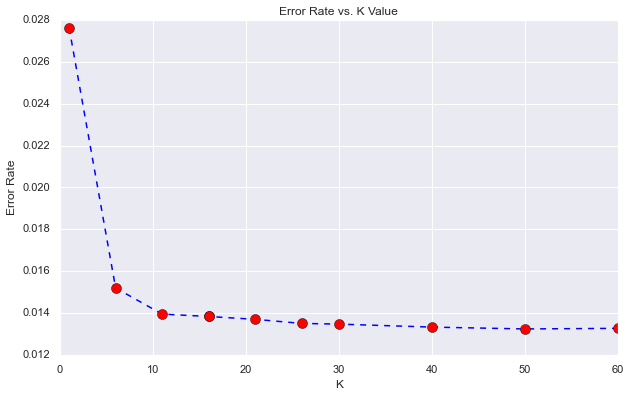

In [181]:
plot_x = [1,6,11,16,16,21,26,30,40,50,60]

plt.figure(figsize=(10,6))
plt.plot(plot_x,error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [16]:

# Fe
X_train =train_df_fe.drop('Fe',axis =1)
y_train = train_df_fe['Fe']
X_test = (test_df_fe['Albedo'].to_numpy()).reshape(test_df_fe['Albedo'].to_numpy().size,1)

knn = KNeighborsRegressor(n_neighbors=25)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
train.loc[train.Fe.isnull(), 'Fe'] = y_pred

# Al

X_train =train_df_al.drop('Al',axis =1)
y_train = train_df_al['Al']
X_test = (test_df_al['Albedo'].to_numpy()).reshape(test_df_al['Albedo'].to_numpy().size,1)


knn = KNeighborsRegressor(n_neighbors=25)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
train.loc[train.Al.isnull(), 'Al'] = y_pred

# Mg

X_train =train_df_mg.drop('Mg',axis =1)
y_train = train_df_mg['Mg']
X_test = (test_df_mg['Albedo'].to_numpy()).reshape(test_df_mg['Albedo'].to_numpy().size,1)

knn = KNeighborsRegressor(n_neighbors=25)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
train.loc[train.Mg.isnull(), 'Mg'] = y_pred

# S
X_train =train_df_s.drop('S',axis =1)
y_train = train_df_s['S']
X_test = (test_df_s['Albedo'].to_numpy()).reshape(test_df_s['Albedo'].to_numpy().size,1)

knn = KNeighborsRegressor(n_neighbors=25)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
train.loc[train.S.isnull(), 'S'] = y_pred


# Ca
X_train =train_df_ca.drop('Ca',axis =1)
y_train = train_df_ca['Ca']
X_test = (test_df_ca['Albedo'].to_numpy()).reshape(test_df_ca['Albedo'].to_numpy().size,1)

knn = KNeighborsRegressor(n_neighbors=25)
knn.fit(X_train, y_train)
y_pred = knn.predict(X_test)
train.loc[train.Ca.isnull(), 'Ca'] = y_pred


**Lets again visualize all the variables to check if the problem has been fixed**

<AxesSubplot:xlabel='Mg', ylabel='Density'>

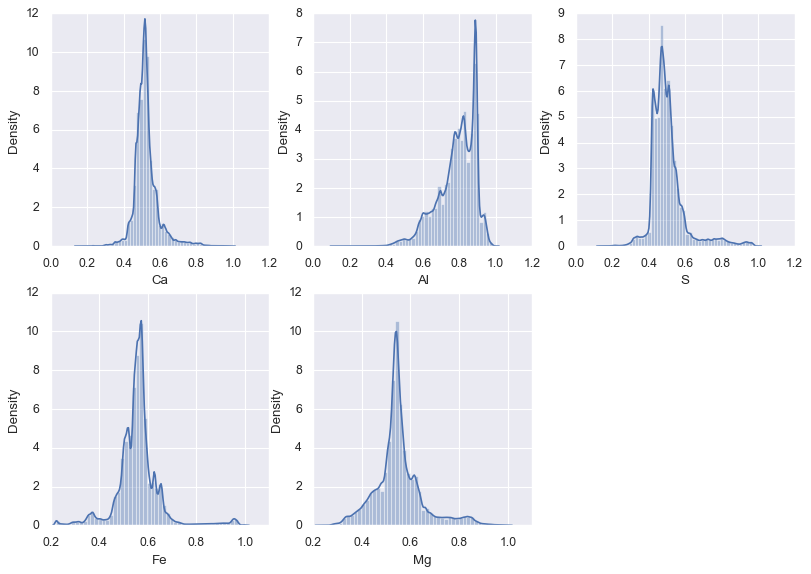

In [17]:
figure(num=None, figsize=(12, 8), dpi=80, facecolor='w', edgecolor='k')

plt.subplot(2, 3, 1)
sns.distplot(train['Ca'])

plt.subplot(2, 3, 2)
sns.distplot(train['Al'])

plt.subplot(2, 3, 3)
sns.distplot(train['S'])

plt.subplot(2, 3, 4)
sns.distplot(train['Fe'])

plt.subplot(2, 3, 5)
sns.distplot(train['Mg'])

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1036800 entries, 0 to 1036799
Data columns (total 6 columns):
 #   Column  Non-Null Count    Dtype  
---  ------  --------------    -----  
 0   Albedo  1036800 non-null  float64
 1   Fe      1036800 non-null  float64
 2   Al      1036800 non-null  float64
 3   Mg      1036800 non-null  float64
 4   S       1036800 non-null  float64
 5   Ca      1036800 non-null  float64
dtypes: float64(6)
memory usage: 47.5 MB


In [19]:
train.describe()

,Albedo,Fe,Al,Mg,S,Ca
count,1.036800e+06,1.036800e+06,1.036800e+06,1.036800e+06,1.036800e+06,1.036800e+06
mean,4.144590e-01,5.583823e-01,7.882348e-01,5.513112e-01,5.026000e-01,5.240549e-01
std,1.165033e-01,8.832236e-02,1.033879e-01,9.775761e-02,9.525281e-02,6.649115e-02
min,0.000000e+00,2.235294e-01,1.137255e-01,2.274510e-01,1.333333e-01,1.450980e-01
25%,3.372549e-01,5.200000e-01,7.333333e-01,5.058824e-01,4.470588e-01,4.901961e-01
50%,4.039216e-01,5.593726e-01,8.078431e-01,5.411765e-01,4.848628e-01,5.174902e-01
75%,4.862745e-01,5.843138e-01,8.745098e-01,5.843138e-01,5.287843e-01,5.450981e-01
max,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00,1.000000e+00



**Let's explore some relationships among the variables if any across the entire data set**

In [20]:
train.corr()

,Albedo,Fe,Al,Mg,S,Ca
Albedo,1.000000,0.133408,0.042274,-0.027427,-0.122434,-0.095289
Fe,0.133408,1.000000,-0.197424,0.353585,0.393209,0.280492
Al,0.042274,-0.197424,1.000000,-0.471030,-0.493185,-0.378770
Mg,-0.027427,0.353585,-0.471030,1.000000,0.570043,0.501804
S,-0.122434,0.393209,-0.493185,0.570043,1.000000,0.772829
Ca,-0.095289,0.280492,-0.378770,0.501804,0.772829,1.000000


<AxesSubplot:>

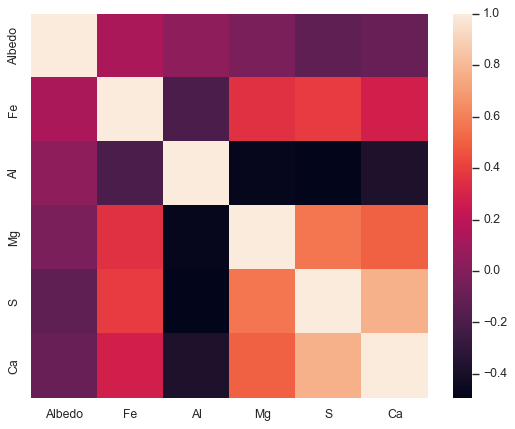

In [21]:
sns.heatmap(train.corr())


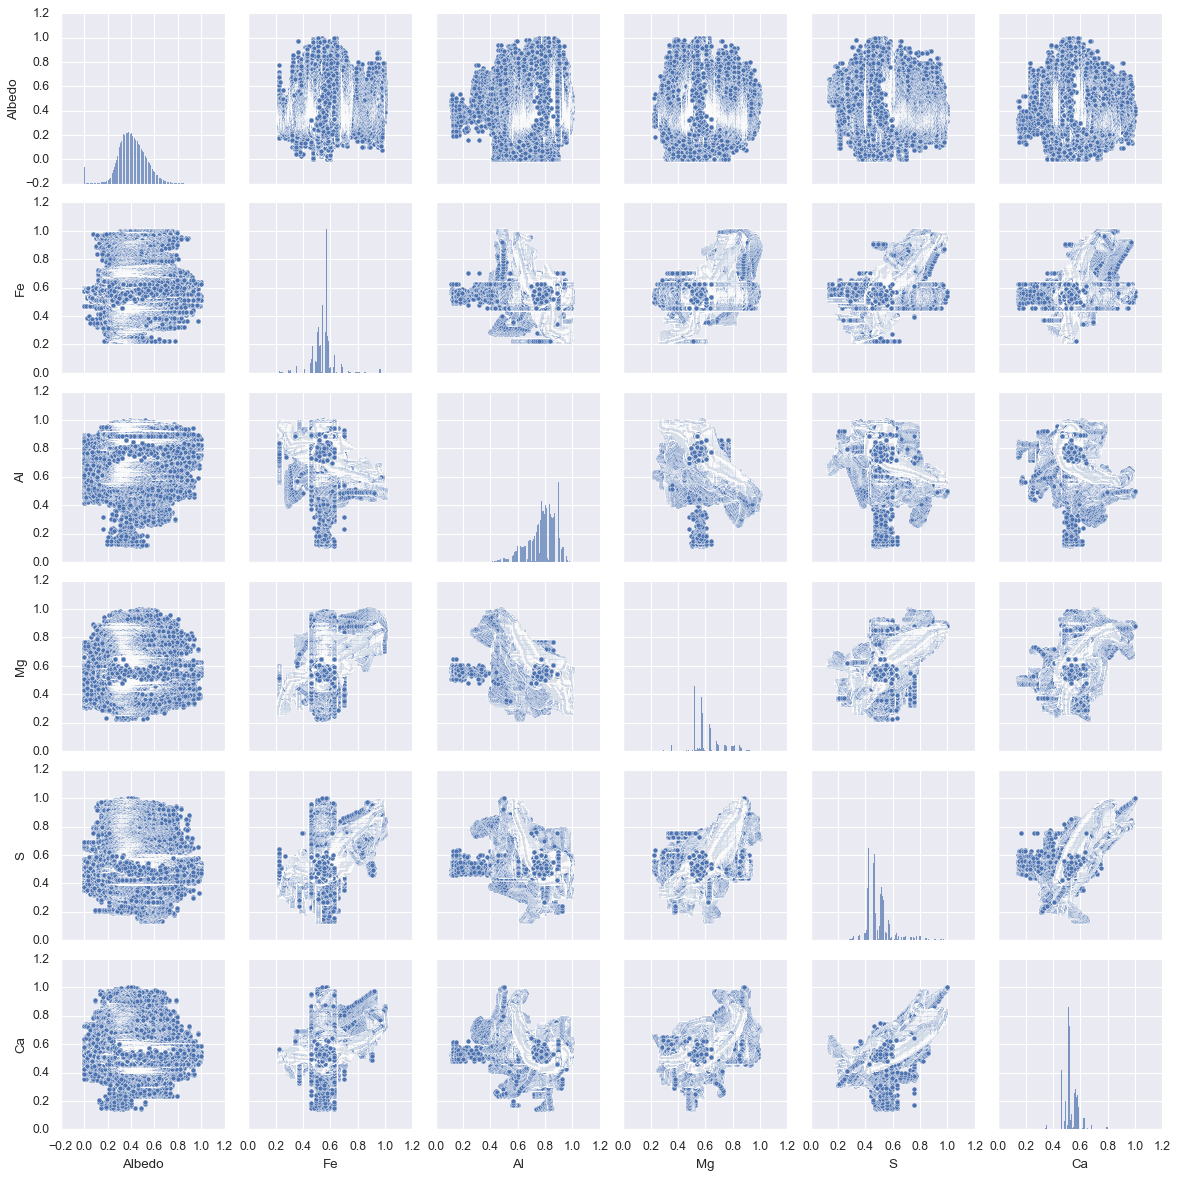

In [22]:
sns.pairplot(train)

## Ingsights from the plots above

1) Some of the variables are heavly skewed.

2) Little correlation can be obeserved among the dependent variables(which may not be useful for some of the models), and negligible correlation between albedo and chemical composition can be seen.

3) Due to the reasons mentioned above we cant expect very accurate and robust model 

**---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------**

# Multi Output Regression


In multioutput regression, typically the outputs are dependent upon the input and upon each other. This means that often the outputs are not independent of each other and may require a model that predicts both outputs together or each output contingent upon the other outputs.

Some regression machine learning algorithms support multiple outputs directly.

This includes most of the popular machine learning algorithms implemented in the scikit-learn library, such as:

- LinearRegression 
- KNeighborsRegressor
- RandomForestRegressor 

**I will try the above models and I will also use the wrapper models such as Direct Multioutput Regression and 
Chained Multioutput Regression to check if XGboost, which gave good results previously, works well or not.
At last I will use a more intuitive neural network model with 5 outputs and then use the bes model to predict for lower half of mercury albedo**
 

****For all the models these two steps will be followed :-****

**1) Fitting the regressor object on the hyperparameters obtained using GridSearch**

**2) Print the details about the evaluation metrics**

Note the final peformace would be compared using **Mean Square Error(MSE)** as its a good evaluation metric for regression model

In [36]:
X = train.iloc[:, 0:1].values
y = train.iloc[:, 1:].values


In [37]:
from sklearn.preprocessing import StandardScaler

sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X.reshape(X.shape[0],1))
y_train =  sc_y.fit_transform(y)

## Linear Regression

In [71]:
from sklearn.linear_model import LinearRegression
regressor = LinearRegression()
regressor.fit(X_train, y_train)

y_pred = regressor.predict(X_train)


In [72]:
print('MAE:', metrics.mean_absolute_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('MSE:', metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred))))

MAE: 0.061486688718555296
MSE: 0.008239858222914646
RMSE: 0.09077366480931925


## The MSE is 0.008239858222914646


## KNN

In [65]:
error_rate=[]
for i in range(1,30,2):
    
    knn = KNeighborsRegressor(n_neighbors=i,metric='euclidean')
    knn.fit(X_train,y_train)
    pred_i = knn.predict(X_train)
    print('k=>',i,' error',metrics.mean_squared_error(pred_i,y_train))
    error_rate.append(metrics.mean_squared_error(pred_i,y_train))

k=> 1  error 1.9041581695455423
k=> 3  error 1.2561557605568012
k=> 5  error 1.133971424325038
k=> 7  error 1.096549856993301
k=> 9  error 1.0736271905132475
k=> 11  error 1.0685217415881714
k=> 13  error 1.0561906628387374
k=> 15  error 1.0465873047236027
k=> 17  error 1.0340890630969972
k=> 19  error 1.0266629209657863
k=> 21  error 1.0277062132221473
k=> 23  error 1.027065712312473
k=> 25  error 1.0222676084054836
k=> 27  error 1.020496727761065
k=> 29  error 1.018650275321138


Text(0, 0.5, 'Error Rate')

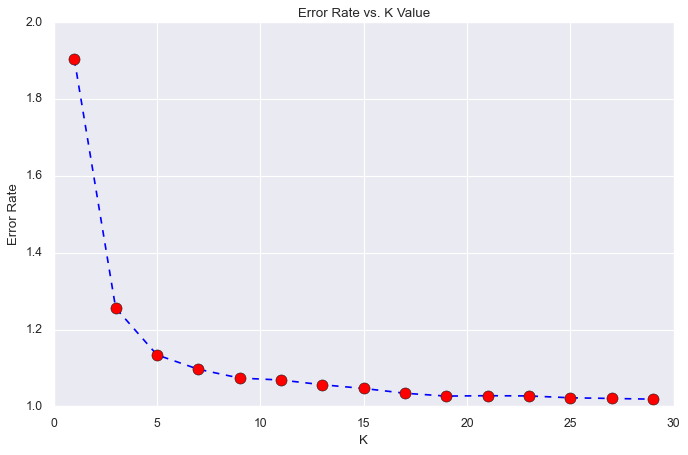

In [66]:
plt.figure(figsize=(10,6))
plt.plot(range(1,30,2),error_rate,color='blue', linestyle='dashed', marker='o',
         markerfacecolor='red', markersize=10)
plt.title('Error Rate vs. K Value')
plt.xlabel('K')
plt.ylabel('Error Rate')

In [69]:
regressor = KNeighborsRegressor(n_neighbors=25,metric='euclidean')
regressor.fit(X_train, y_train)


y_pred = regressor.predict(X_train)


In [70]:

print('MAE:', metrics.mean_absolute_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('MSE:', metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred))))

MAE: 0.06293446066432423
MSE: 0.008517812222464106
RMSE: 0.09229199435738783


# The MSE is 0.008517812222464106

## Random Forest

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor 

param_grid = [
{'n_estimators': [50,250,500],
 'max_depth': [5,10], 
 'max_features' : ['auto', 'sqrt', 'log2'],
'min_samples_leaf':[5,10]


}
]

grid_search_forest = GridSearchCV(regressor, param_grid, cv=2,verbose=5)
grid_search_forest.fit(X_train, y_train)

grid_search_forest.best_params_

In [103]:

rf = RandomForestRegressor(max_depth=10,min_samples_leaf=5,n_estimators=10)
error_rate_train=[]

for iter in range(10):
    rf.fit(X_train, y_train)
    y_train_predicted = rf.predict(X_train)
    mse_train = metrics.mean_squared_error(y_train, y_train_predicted)
    error_rate_train.append( metrics.mean_squared_error(y_train, y_train_predicted))
    print("n_estimators: {} Train mse: {} ".format(rf.n_estimators , mse_train))
    rf.n_estimators += 100

error_rate_train



[0.9600023357331633,
 0.9599824191190722,
 0.9599801682417926,
 0.9599824344501172,
 0.9599837364858562,
 0.9599832609160626]

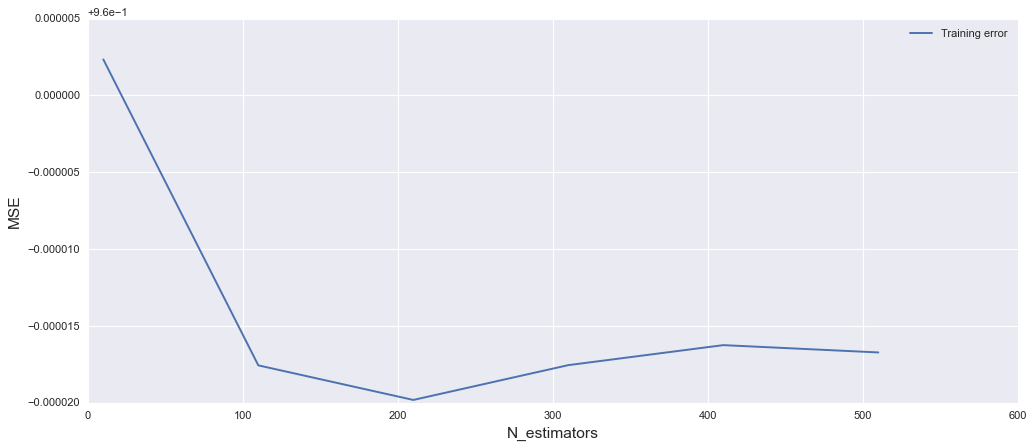

In [104]:
plt.figure(figsize=(15,6))


plt.style.use('seaborn')
plt.plot(range(10,610,100),error_rate_train, label = 'Training error')
# plt.plot(range(100,1200,100),error_rate_test, label = 'Validation error')
plt.ylabel('MSE', fontsize = 14)
plt.xlabel('N_estimators', fontsize = 14)
plt.legend()




In [105]:
regressor = RandomForestRegressor(max_depth=10,min_samples_leaf=5,n_estimators=210) 
 
# fit the regressor with x and y data 
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_train)


In [106]:

print('MAE:', metrics.mean_absolute_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('MSE:', metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred))))

MAE: 0.05888045187739951
MSE: 0.007993775066409383
RMSE: 0.08940791389138539


# The MSE is MSE: 0.007993775066409383

# Xgboost using MultiOutputRegressor wrapper


**How normal MultiOutputRegressor works :-**

For example, if a multioutput regression problem required the prediction of three values y1, y2 and y3 given an input X, then this could be partitioned into three single-output regression problems:

- Problem 1: Given X, predict y1.

- Problem 2: Given X, predict y2.

- Problem 3: Given X, predict y3.

In [111]:
from sklearn.multioutput import MultiOutputRegressor
import xgboost
regressor=xgboost.XGBRegressor()


wrapper = MultiOutputRegressor(regressor)
wrapper.fit(X_train,y_train)
y_pred = wrapper.predict(X_train)


In [74]:

print('MAE:', metrics.mean_absolute_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('MSE:', metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred))))

MAE: 0.05882737947486376
MSE: 0.007991978600932065
RMSE: 0.08939786687014442


In [117]:
import pickle
filename = 'Best_Model_XG_boost.sav'
pickle.dump(regressor, open(filename, 'wb'))

## The MSE is  0.007991978600932065

# Xgboost using Chained Multioutput Regression wrapper


**How normal Chained MultiOutputRegressor works :-**

For example, if a multioutput regression problem required the prediction of three values y1, y2 and y3 given an input X, then this could be partitioned into three dependent single-output regression problems as follows:

- Problem 1: Given X, predict y1.
- Problem 2: Given X and yhat1, predict y2.
- Problem 3: Given X, yhat1, and yhat2, predict y3.

In [75]:
from sklearn.multioutput import RegressorChain
import xgboost
regressor=xgboost.XGBRegressor()

wrapper =RegressorChain(regressor)
wrapper.fit(X_train,y_train)
y_pred = wrapper.predict(X_train)


In [77]:

print('MAE:', metrics.mean_absolute_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('MSE:', metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred))))

MAE: 0.0619765022401237
MSE: 0.008699825503922025
RMSE: 0.0932728551290354


## The MSE is 0.008699825503922025


# Neural Network

In [38]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Activation,Dropout
from tensorflow.keras.models import Model
from tensorflow import keras


In [78]:
def create_model(learn_rate=0.01):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(2))
    model.add(tf.keras.layers.Dense(10))
    model.add(tf.keras.layers.Dense(5))

    opt = keras.optimizers.Adam(learning_rate=learn_rate)
    model.compile(loss='mse', optimizer=opt)
    return model

In [82]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import GridSearchCV

model = KerasRegressor(build_fn=create_model,verbose=4)
learn_rate = [0.001,0.01,0.1,1]
batch_size = [32]
epochs = [10]
param_grid = dict(learn_rate=learn_rate,batch_size=batch_size,epochs=epochs)

grid = GridSearchCV(estimator=model, param_grid=param_grid, cv=2,verbose=10)
grid_result = grid.fit(X_train, y_train)

Fitting 2 folds for each of 4 candidates, totalling 8 fits
[CV] batch_size=32, epochs=10, learn_rate=0.001 ......................
Epoch 1/10


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  batch_size=32, epochs=10, learn_rate=0.001, score=-1.733, total= 1.7min
[CV] batch_size=32, epochs=10, learn_rate=0.001 ......................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.7min remaining:    0.0s


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  batch_size=32, epochs=10, learn_rate=0.001, score=-0.654, total= 1.6min
[CV] batch_size=32, epochs=10, learn_rate=0.01 .......................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  3.3min remaining:    0.0s


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  batch_size=32, epochs=10, learn_rate=0.01, score=-1.738, total= 1.6min
[CV] batch_size=32, epochs=10, learn_rate=0.01 .......................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:  4.9min remaining:    0.0s


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  batch_size=32, epochs=10, learn_rate=0.01, score=-0.659, total= 1.7min
[CV] batch_size=32, epochs=10, learn_rate=0.1 ........................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:  6.6min remaining:    0.0s


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  batch_size=32, epochs=10, learn_rate=0.1, score=-1.754, total= 1.7min
[CV] batch_size=32, epochs=10, learn_rate=0.1 ........................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  8.2min remaining:    0.0s


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  batch_size=32, epochs=10, learn_rate=0.1, score=-0.648, total= 1.7min
[CV] batch_size=32, epochs=10, learn_rate=1 ..........................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   6 out of   6 | elapsed:  9.9min remaining:    0.0s


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  batch_size=32, epochs=10, learn_rate=1, score=-1.667, total= 1.6min
[CV] batch_size=32, epochs=10, learn_rate=1 ..........................
Epoch 1/10


[Parallel(n_jobs=1)]: Done   7 out of   7 | elapsed: 11.5min remaining:    0.0s


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10
[CV]  batch_size=32, epochs=10, learn_rate=1, score=-4.024, total= 1.7min
Epoch 1/10


[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.2min remaining:    0.0s
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed: 13.2min finished


Epoch 2/10
Epoch 3/10
Epoch 4/10
Epoch 5/10
Epoch 6/10
Epoch 7/10
Epoch 8/10
Epoch 9/10
Epoch 10/10


In [83]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))


Best: -1.193443 using {'batch_size': 32, 'epochs': 10, 'learn_rate': 0.001}


In [84]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(2))
model.add(tf.keras.layers.Dense(10))
model.add(tf.keras.layers.Dense(5))
opt = keras.optimizers.Adam(learning_rate=0.001)

model.compile(optimizer='AdaGrad', loss='mse')
# This builds the model for the first time:
history  = model.fit(X_train, y_train, batch_size=32, epochs=10)

Epoch 1/10
32400/32400 [==============================] - 20s 618us/step - loss: 1.0351
Epoch 2/10
32400/32400 [==============================] - 20s 618us/step - loss: 0.9911
Epoch 3/10
32400/32400 [==============================] - 20s 619us/step - loss: 0.9911ETA - ETA: 0s - loss: 0.9
Epoch 4/10
32400/32400 [==============================] - 20s 622us/step - loss: 0.99110s - loss
Epoch 5/10
32400/32400 [==============================] - 20s 620us/step - loss: 0.9911
Epoch 6/10
32400/32400 [==============================] - 20s 620us/step - loss: 0.9911
Epoch 7/10
32400/32400 [==============================] - 20s 620us/step - loss: 0.9911
Epoch 8/10
32400/32400 [==============================] - 20s 624us/step - loss: 0.9911
Epoch 9/10
32400/32400 [==============================] - 20s 616us/step - loss: 0.9911
Epoch 10/10
32400/32400 [==============================] - 20s 619us/step - loss: 0.9911


In [85]:
model.summary()


Model: "sequential_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_61 (Dense)             (32, 2)                   4         
_________________________________________________________________
dense_62 (Dense)             (32, 10)                  30        
_________________________________________________________________
dense_63 (Dense)             (32, 5)                   55        
Total params: 89
Trainable params: 89
Non-trainable params: 0
_________________________________________________________________


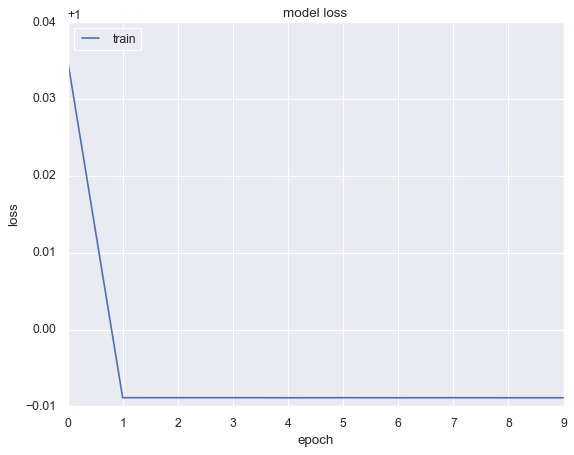

In [86]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [109]:
y_pred = model.predict(X_train)

print('MAE:', metrics.mean_absolute_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('MSE:', metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred))))

MAE: 0.06148645733982101
MSE: 0.008239864792106802
RMSE: 0.09077370099377242


## The MSE is 0.008239864792106802


## Sklearn's - Neural Network Regressor(MLPRegressor)

In [125]:
from sklearn.neural_network import MLPRegressor
regressor = MLPRegressor().fit(X_train, y_train)
y_pred = regressor.predict(X_train)


In [126]:

print('MAE:', metrics.mean_absolute_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('MSE:', metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred)))
print('RMSE:', np.sqrt(metrics.mean_squared_error(sc_y.inverse_transform(y_train), sc_y.inverse_transform(y_pred))))

MAE: 0.059882774572694385
MSE: 0.008047336148208833
RMSE: 0.0897069459306738


## The MSE is  0.008047336148208833

# Final Results

**The lowest MSE obtained was with the tuned XGBOOST model** 

## MSE = 0.007991978600932065

Predicting for bottom half using this model

In [119]:
from sklearn.multioutput import RegressorChain
import xgboost
regressor=xgboost.XGBRegressor()
wrapper =RegressorChain(regressor)
wrapper.fit(X_train,y_train)

bottom_albedo = mercury_bottom.flatten()

test_predictions  = wrapper.predict(bottom_albedo.reshape(1036800,1))

In [124]:
test_final  = pd.DataFrame(sc_y.inverse_transform(test_predictions), columns = ['Fe','Al','Mg','S','Ca'])

test_final.head()

,Fe,Al,Mg,S,Ca
0,0.541922,0.786952,0.556812,0.462441,0.484005
1,0.566629,0.757382,0.526328,0.475923,0.527736
2,0.561151,0.890483,0.498289,0.452601,0.507011
3,0.566629,0.757382,0.526328,0.475923,0.527736
4,0.541922,0.786952,0.556812,0.462441,0.484005


### Insights 

- Again as Expected XGboost with Multioutput Regression wrapper peformed fairly well.
- The results were not as good as compared to the MOON model
- Very low relation between albedo and compostion may be a reason. Also, extenstive hyperparater tuning couldnt be done due to lack of time and computational power